<a href="https://colab.research.google.com/github/kartikrawool/sentiment_analysis/blob/master/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis - COVID-19 Tweets
Project By:
> Kartik Rawool

> Anurag Tiwari 

> Rameshta Vishwakarma

## Mounting Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Collection using Twitter API and Twarc

In [0]:
from twarc import Twarc
import pandas as pd
from pathlib import Path

In [0]:
df = pd.DataFrame()

#Keys of Twitter API App
consumer_key = '***'
consumer_secretkey = '***'
access_token_key = '***'
acess_token_secretkey = '***'

#Twarc object creation
t = Twarc(consumer_key, consumer_secretkey, access_token_key, acess_token_secretkey)

#as there are many files containing tweet id we need parse in a given path where the .txt file are stored
for path in Path('c:/KARTIK NEW/ML Internship/COVID-19-TweetIDs/April').iterdir():
    if path.name.endswith('.txt'):#checking txt file
        id_file = path
        print('hydrating {}'.format(id_file))
        csv_path = id_file.with_suffix('.csv')#adding suffix to save as csv file
        df = pd.DataFrame( tweet for tweet in t.hydrate(id_file.open()))#hydrating each tweetid
        print("saved to {}".format(csv_path))
        df.to_csv(csv_path)#saving to csv

## Reading Labelled Training DataSet

In [0]:
import pandas as pd
import numpy as np

cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("/content/drive/My Drive/Project_ML/training.1600000.processed.noemoticon.csv",header = None,encoding = "ISO-8859-1",names=cols)
df.head()


,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
df.shape

(1600000, 6)

In [0]:
df.sentiment.value_counts()#checking for imbalance in data

4    800000
0    800000
Name: sentiment, dtype: int64

In [0]:
#dropping unnecessary columns
df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [0]:
df[df.sentiment == 4].head(10)

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [0]:
df['pre_clean_len'] = [len(t) for t in df.text]

In [0]:
#creating a dictionary of columns and type of data
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}
pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


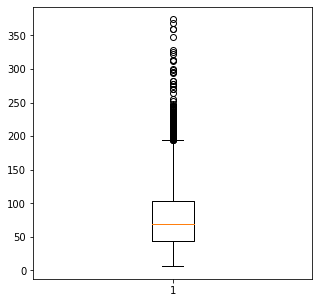

In [0]:
#plotting a boxplot to known the distribution of the lengths of the tweets
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [0]:
#tweets which have length more than 140
df[df.pre_clean_len > 140].head(10)

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141


## Data Preprocessing

In [0]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


1. Removing @User

In [0]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [0]:
import re
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

2. Removing urls

In [0]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [0]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

3. Encoding Decoding utf-8

In [0]:
df.text[226]

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [0]:
testing = df.text[226].encode().decode("utf-8-sig")
testing

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [0]:
testing.replace(u"\ufffd", "?")

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

4. Removing Punctuations and special characters

In [0]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [0]:
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

### Combining all the operations into a function

In [0]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [0]:

df = pd.read_csv("/content/drive/My Drive/Project_ML/training.1600000.processed.noemoticon.csv",header=None,
                 usecols=[0,5],names=['sentiment','text'],encoding = "ISO-8859-1")
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Applying the function on each tweet of Training Dataset

In [0]:
%%time
print("Cleaning the tweets...\n")
clean_tweet_texts = []
for i in range(0,len(df)):
    if( (i+1)%100000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, len(df) ))                                                                 
    clean_tweet_texts.append(tweet_cleaner_updated(df['text'][i]))

Cleaning the tweets...

Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed
CPU times: user 7min 59s, sys: 29.5 s, total: 8min 29s
Wall time: 8min 29s


In [0]:
#exporting the cleaned dataframe to csv to ue later
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.to_csv('/content/drive/My Drive/Project_ML/clean_tweet.csv',encoding='utf-8')

In [0]:
#importing cleanef dataframe
csv = '/content/drive/My Drive/Project_ML/clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


### Checking null values and dropping them 

In [0]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [0]:
my_df[my_df.isnull().any(axis=1)].head()

,text,target
208,NaN,0
249,NaN,0
282,NaN,0
398,NaN,0
430,NaN,0


In [0]:
np.sum(my_df.isnull().any(axis=1))

3959

In [0]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1596041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


## Word Cloud

### Negative Word Cloud

In [0]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

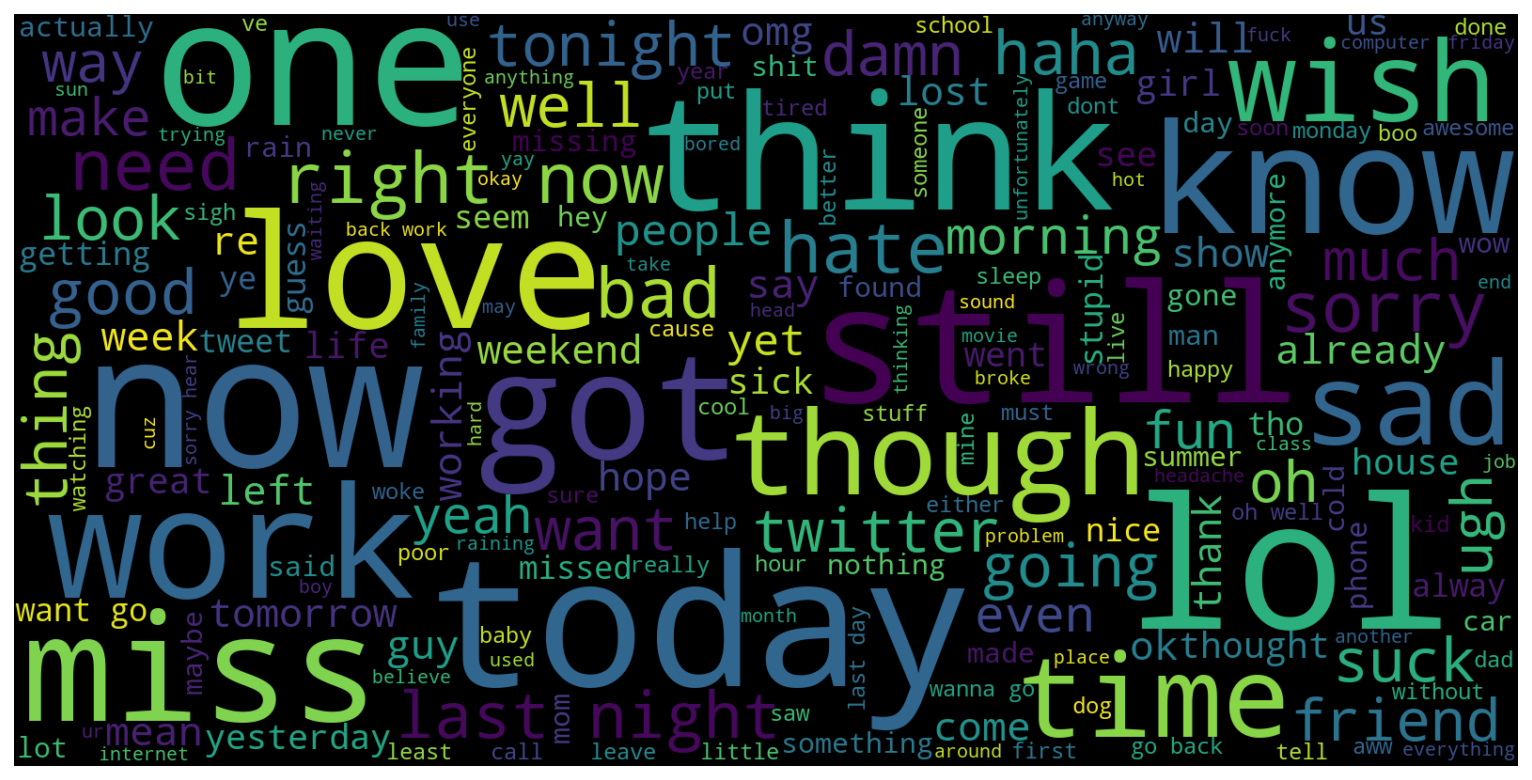

In [0]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Positive Word CLoud

In [0]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

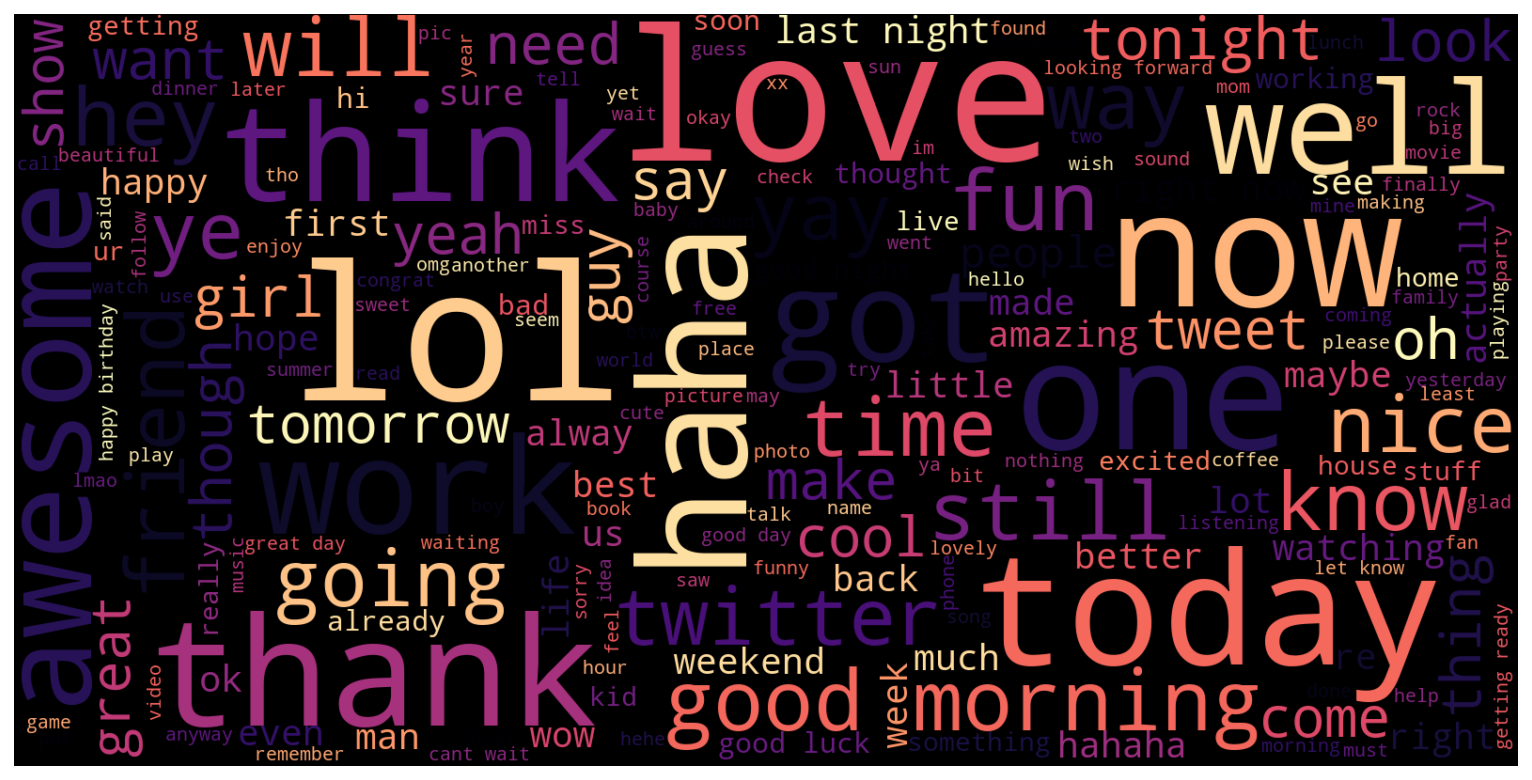

In [0]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Train and Test Split

In [0]:
x = my_df.text
y = my_df.target

In [0]:
from sklearn.model_selection import train_test_split 
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [0]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564120 entries with 50.02% negative, 49.98% positive
Validation set has total 15960 entries with 49.45% negative, 50.55% positive
Test set has total 31921 entries with 49.57% negative, 50.43% positive


## Applying Supervised Machine Learning Models

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np

In [0]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))

In [0]:
%%time
lr = LogisticRegression()
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.55%
accuracy score: 82.38%
model is 31.84% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6331                1562
positive                1250                6817
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82      7893
    positive       0.81      0.85      0.83      8067

    accuracy                           0.82     15960
   macro avg       0.82      0.82      0.82     15960
weighted avg       0.82      0.82      0.82     15960

CPU times: user 3min 32s, sys: 29.9 s, total: 4min 2s
Wall time: 3min 33s


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
lr = LogisticRegression()
tg_pipeline = Pipeline([
        ('vectorizer', tvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.55%
accuracy score: 82.15%
model is 31.60% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6349                1544
positive                1305                6762
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.80      0.82      7893
    positive       0.81      0.84      0.83      8067

    accuracy                           0.82     15960
   macro avg       0.82      0.82      0.82     15960
weighted avg       0.82      0.82      0.82     15960



In [0]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

In [0]:
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    ]
zipped_clf = zip(names,classifiers)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

In [0]:
%%time
trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.55%
accuracy score: 82.15%
model is 31.60% more accurate than null accuracy
train and test time: 260.66s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
null accuracy: 50.55%
accuracy score: 82.33%
model is 31.79% more accurate than null accuracy
train and test time: 254.28s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_inte

## Lexicon Approach

### TextBlob

In [0]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
analysis = TextBlob("TextBlob sure looks like it has some interesting features!")
print(dir(analysis))

['__add__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cmpkey', '_compare', '_create_sentence_objects', '_strkey', 'analyzer', 'classifier', 'classify', 'correct', 'detect_language', 'ends_with', 'endswith', 'find', 'format', 'index', 'join', 'json', 'lower', 'ngrams', 'noun_phrases', 'np_counts', 'np_extractor', 'parse', 'parser', 'polarity', 'pos_tagger', 'pos_tags', 'raw', 'raw_sentences', 'replace', 'rfind', 'rindex', 'sentences', 'sentiment', 'sentiment_assessments', 'serialized', 'split', 'starts_with', 'startswith', 'string', 'strip', 'stripped', 'subjectivity', 'tags', 'title', 'to_json', 'tokenize', 'tokenizer', 'tokens', 'tra

In [0]:
print(analysis.sentiment)

Sentiment(polarity=0.5625, subjectivity=0.6944444444444444)


In [0]:
df = pd.read_csv("/content/training_tweets.csv")

In [0]:
df

,Unnamed: 0,sentiments,new_tweets
0,1,0,awww s bummer shoulda got david carr third day...
1,2,0,upset he t update facebook texting and might c...
2,3,0,dived many times ball managed save 50 the rest...
3,4,0,whole body feels itchy like on fire
4,5,0,no s not behaving all m mad am here i t see al...
...,...,...,...
59995,59996,1,really wants go see 17 because zac efron so am...
59996,59997,1,thank
59997,59998,1,dreaming you
59998,59999,1,saw clip online good show


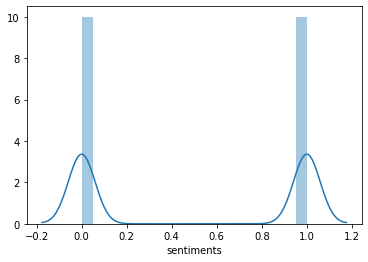

In [0]:
%matplotlib inline
sns.distplot(df['sentiments'])

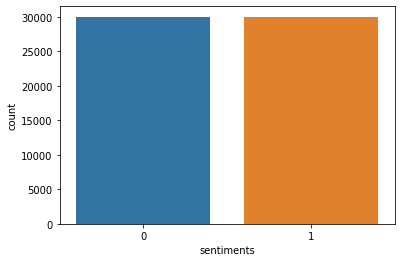

In [0]:
sns.countplot(x='sentiments', data=df)

In [0]:
df['new_tweets'][0]

'awww s bummer shoulda got david carr third day do d'

In [0]:
text_blob_object = TextBlob(df['new_tweets'][1])
print(text_blob_object.sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


In [0]:
import csv
infile = 'training_tweets.csv'

sent = []
with open(infile, 'r') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        sentence = row[2]
        blob = TextBlob(sentence)
        sent.append(blob.sentiment.polarity)
sent.pop(0)

0.0

In [0]:
def pol_sent(polarity):
    if polarity<=0:
        return 0
    elif polarity>0:
        return 1
sent_new = []
for i in sent:
    sent_new.append(pol_sent(i))

In [0]:
y = list(df.iloc[:,1].values)
accuracy = []
for val in range(len(sent_new)):
    if sent_new[val] == y[val]:
        accuracy.append("True")
    else:
        accuracy.append("False")

In [0]:
print(accuracy.count("True"))
print(accuracy.count("False"))

37500
22500


In [0]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print(classification_report(df['sentiments'].astype(str),df['new_tweets'].astype(str)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Vader Lexicon

In [0]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/My Drive/Project_ML/sentiment_m140_.csv")
df.head(2)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [0]:
df = df.drop(["ids","date","flag","user"],axis = 1)
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [0]:
import nltk

In [0]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [0]:
sid = SentimentIntensityAnalyzer()

In [0]:
sid.polarity_scores(df.iloc[0]['text'])

{'compound': -0.0173, 'neg': 0.129, 'neu': 0.745, 'pos': 0.126}

In [0]:
text = df["text"].to_numpy()
new_text = []
for i in text:
  new_text.append(sid.polarity_scores(str(i)))


In [0]:
df['scores'] = new_text
df.head()

,target,text,scores
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","{'neg': 0.129, 'neu': 0.745, 'pos': 0.126, 'co..."
1,0,is upset that he can't update his Facebook by ...,"{'neg': 0.303, 'neu': 0.697, 'pos': 0.0, 'comp..."
2,0,@Kenichan I dived many times for the ball. Man...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp..."
3,0,my whole body feels itchy and like its on fire,"{'neg': 0.321, 'neu': 0.5, 'pos': 0.179, 'comp..."
4,0,"@nationwideclass no, it's not behaving at all....","{'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'comp..."


In [0]:
class_tweet = []
for i in new_text:
  if i['pos']>=0.5:
    class_tweet.append(1)
  elif i['neg']>0.5:
    class_tweet.append(0)
  elif i['neg']>i['pos']:
    class_tweet.append(0)
  elif i['neg']<=i['pos']:
    class_tweet.append(1)
len(class_tweet)

60000

In [0]:
df['pred_class'] = class_tweet

In [0]:
df.head()

,target,text,scores,pred_class
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","{'neg': 0.129, 'neu': 0.745, 'pos': 0.126, 'co...",0
1,0,is upset that he can't update his Facebook by ...,"{'neg': 0.303, 'neu': 0.697, 'pos': 0.0, 'comp...",0
2,0,@Kenichan I dived many times for the ball. Man...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",1
3,0,my whole body feels itchy and like its on fire,"{'neg': 0.321, 'neu': 0.5, 'pos': 0.179, 'comp...",0
4,0,"@nationwideclass no, it's not behaving at all....","{'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'comp...",0


In [0]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [0]:
print(classification_report(df['target'],df['pred_class']))

              precision    recall  f1-score   support

           0       0.80      0.41      0.54     30000
           1       0.60      0.90      0.72     30000

    accuracy                           0.65     60000
   macro avg       0.70      0.65      0.63     60000
weighted avg       0.70      0.65      0.63     60000



## Implementing the best model on COVID-19 tweets to get Sentiment


In [0]:
df = pd.read_csv("/content/drive/My Drive/Project_ML_1/combined_tweets.csv")
df.head()
#df = df.loc[df['lang'] == "en"]
#df.head() 

,full_text
0,@charliekirk11 Agree too much coverage of Coro...
1,RT @TheRickyDavila: With the Coronavirus clear...
2,RT @BharatD55138223: #Secrets_Of_Vedas\nReside...
3,RT @misayeon: Dahyun has donated 50 million wo...
4,RT @xx_Y4YA: So the coronavirus is in Houston ...


In [0]:
df.shape

(90540, 1)

In [0]:
df1 = df[['id','full_text']]
# df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df1.drop(['id'],axis=1)

,full_text
0,Nursing Homes Are Starkly Vulnerable to Corona...
1,RT @SARGEE_: But the UK isnât racist apparently
5,RT @BarackObama: Protect yourself and your com...
9,RT @wsvn: #BREAKING - The Ultra Music Festival...
10,âPatheticâ Trump gets blasted after he bla...
...,...
33625,RT @Bvweir: #COVIDã¼19\n#CoronavirusOutbreak\...
33626,RT @DazAltTheory: #æ­¦æ±ç«æ #æ­¦æ± #æ­¦æ±...
33627,RT @amber_khan: I walked into a nursing home i...
33628,RT @PhilEhr: Americans are dying. Shame on you...


In [0]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
pat3 = r'RT'
pat4 = r'coronavirus'#removing this words as it is related to topic and we dont need it for sentiment
pat5 = r'corona'
pat6 = r'virus'
combined_pat = r'|'.join((pat1, pat2,pat3))
combined_pat2 = r'|'.join((pat4, pat5,pat6))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    stripped = re.sub(combined_pat2, '', lower_case)
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], stripped)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

testing = df1.full_text[:100]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner_updated(t))
test_result

['nursing homes are starkly vulnerable to',
 'but the uk isn racist apparently',
 'protect yourself and your community from with common sense precautions wash your hands stay home when sick',
 'breaking the ultra music festival has postponed their event due to the outbreak of the according to the miam',
 'pathetic trump gets blasted after he blames obama for problems with testing',
 'florida cancel ultra music festival because also florida disney world is still open to the thousands of int',
 'now hearing democrats want to attach drug price controls with funding to fight the swamp at it again ridi',
 'fuck your markets want to live',
 'there continue to be zero confirmed cases of the covid in new mexico which we are equipped to test for while',
 'just in cruise ship with onboard some of whom have been exposed to the and are experiencing flu like',
 'we are urging congress to take immediate steps to provide an appropriate level of funding for strong comprehensive public',
 'there not si

In [0]:
%%time
print("Cleaning the tweets...\n")
print(len(df))
clean_tweet_texts = []
testing = df.full_text[:90540]
for t in testing:
    clean_tweet_texts.append(tweet_cleaner_updated(t))
# for i in range(0,len(df1)):
#     if( (i+1)%10000 == 0 ):
#         print("Tweets %d of %d has been processed" % ( i+1, len(df1) ))                                                                 
#     clean_tweet_texts.append(tweet_cleaner_updated(df1['full_text'][i]))

Cleaning the tweets...

90540
CPU times: user 20.3 s, sys: 698 ms, total: 21 s
Wall time: 21.1 s


In [0]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df.to_csv('/content/drive/My Drive/Project_ML_1/clean_tweet_2.csv',encoding='utf-8')

In [0]:
csv = '/content/drive/My Drive/Project_ML_1/clean_tweet_2.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text
0,agree too much coverage of prep taking time fr...
1,with the clearly spreading in the us now know ...
2,secrets of vedas residents of america iran chi...
3,dahyun has donated million won to help prevent...
4,so the is in houston methodist hospital but th...


In [0]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90487 entries, 0 to 90486
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    90487 non-null  object
dtypes: object(1)
memory usage: 707.1+ KB


In [0]:
x = my_df.text

### Applying LinearSVC Model

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
pipeline = Pipeline([
    ('vectorizer', tvec),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', LinearSVC(penalty="l2"))  
])
sentiment_fit = pipeline.fit(x_train, y_train)




In [0]:
y_pred = sentiment_fit.predict(x)

In [0]:
my_df['sentiment'] = y_pred
my_df.head()

,text,sentiment
0,agree too much coverage of prep taking time fr...,0
1,with the clearly spreading in the us now know ...,0
2,secrets of vedas residents of america iran chi...,0
3,dahyun has donated million won to help prevent...,1
4,so the is in houston methodist hospital but th...,0


In [0]:
my_df.to_csv('/content/drive/My Drive/Project_ML_1/sentiment_tweets.csv',encoding='utf-8')

### Negative Word Cloud

In [0]:
neg_tweets = my_df[my_df.sentiment == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

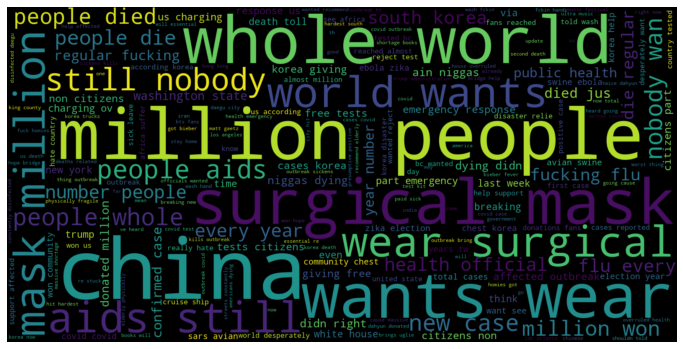

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Positive Word Cloud

In [0]:
pos_tweets = my_df[my_df.sentiment == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

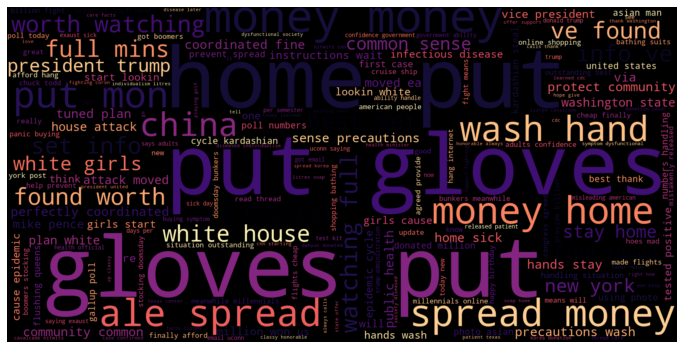

In [0]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Frequency of Sentiments analysed

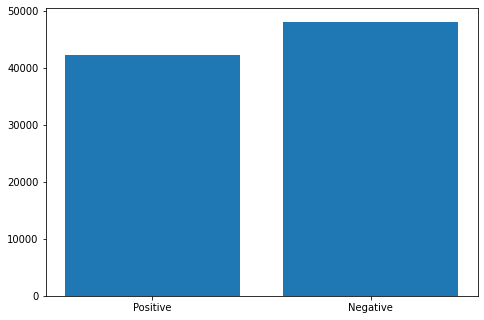

In [0]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiment = ['Positive', 'Negative']
frequency = [len(pos_tweets),len(neg_tweets)]
ax.bar(sentiment,frequency)
plt.show()